In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import scipy.stats as stats
# Import data processing package
from DataProcessing import *
# Import plot packages
import gspplot
from gspplot import *
# Import graph packages
import gsp
from pygsp import graphs, filters, plotting, utils
# Import other packages
from Learning import *
from operator import itemgetter
import warnings; warnings.filterwarnings('ignore')

# 1  Data Processing

## 1.1 Read Data and Crop a Patch

In [3]:
path_cloud   = 'data/Vaihingen3D_Traininig.pts'
# Load dataset as pandas dataframe
cloud        = load_cloud(path_cloud)
newcloud     = cloud_preprocess(cloud)
# Crop a patch from cloud
patch1       = crop_patch(newcloud, (150, 300), (150, 300))
patch2       = crop_patch(newcloud, (200, 350), (50, 200))
intersection = crop_patch(newcloud, (200, 300), (150, 200))

-------------------- Load Data ---------------------
Data Loading...
=> Done.
----------------------------------------------------
--------------- Data Pre-Processing ----------------
Drop duplicates...
=> Duplicates #: 40946, Ratio: 5.43% of the dataset.
Re-center the data...
=> Done.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[150, 300], y:[150, 300].
=> Points left for patch: 157488.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[200, 350], y:[50, 200].
=> Points left for patch: 182404.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[200, 300], y:[150, 200].
=> Points left for patch: 46363.
----------------------------------------------------


## 1.2 Data Visualization

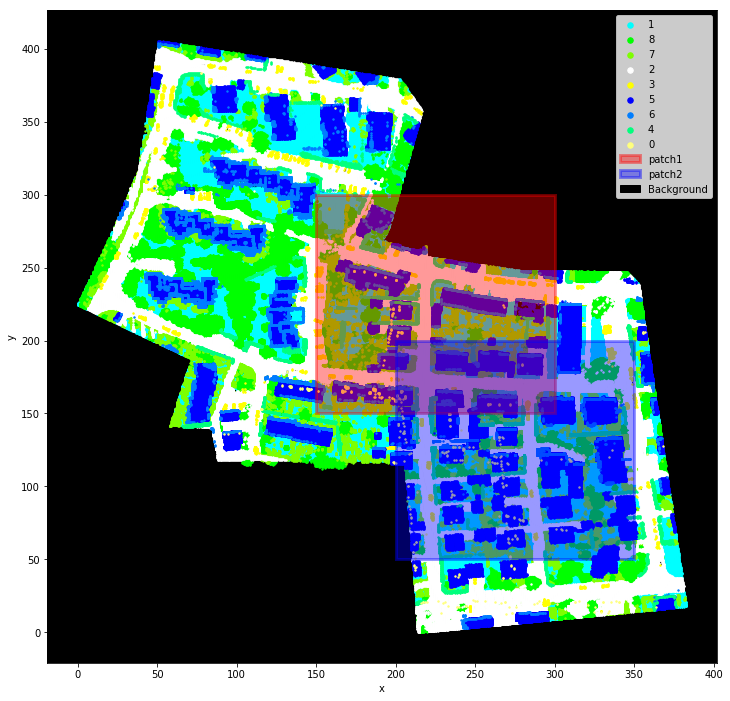

In [4]:
zones = np.array([[150, 300, 150, 300], 
                  [200, 350, 50, 200]])
zones_label = np.array([['red', 'patch1'], 
                        ['blue', 'patch2']])
gspplot.plot_vaihingen_2D_zones(newcloud, zones, zones_label)

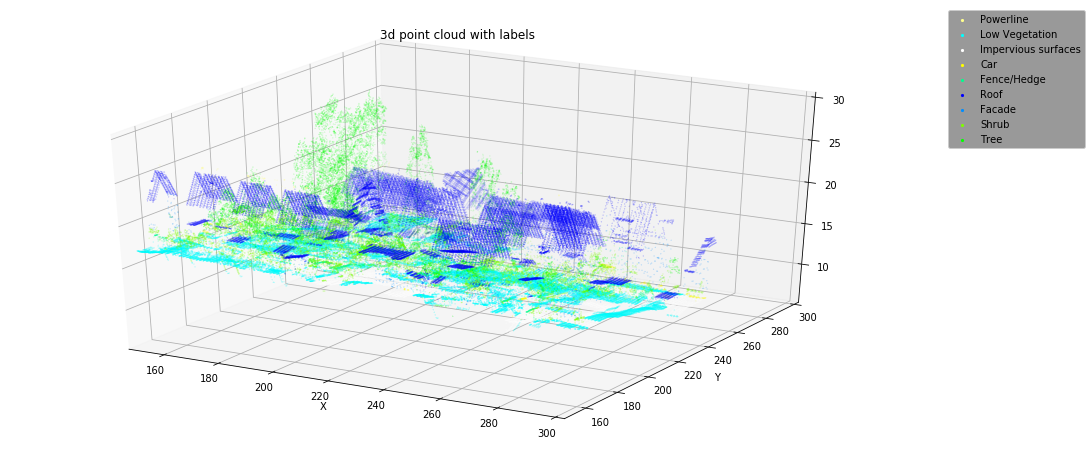

In [5]:
plot_graph_3D(patch1, 
              figsize=(16, 8), 
              marksize=0.02, 
              markerscale=15, 
              xRange=(150, 300), 
              yRange=(150, 300))

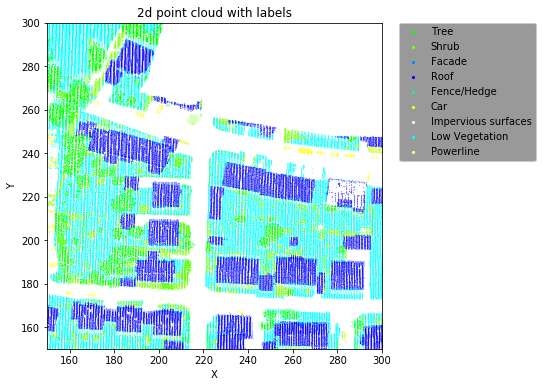

In [6]:
plot_graph_2D(patch1, 
              figsize=(6,6), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(150, 300), 
              yRange=(150, 300))

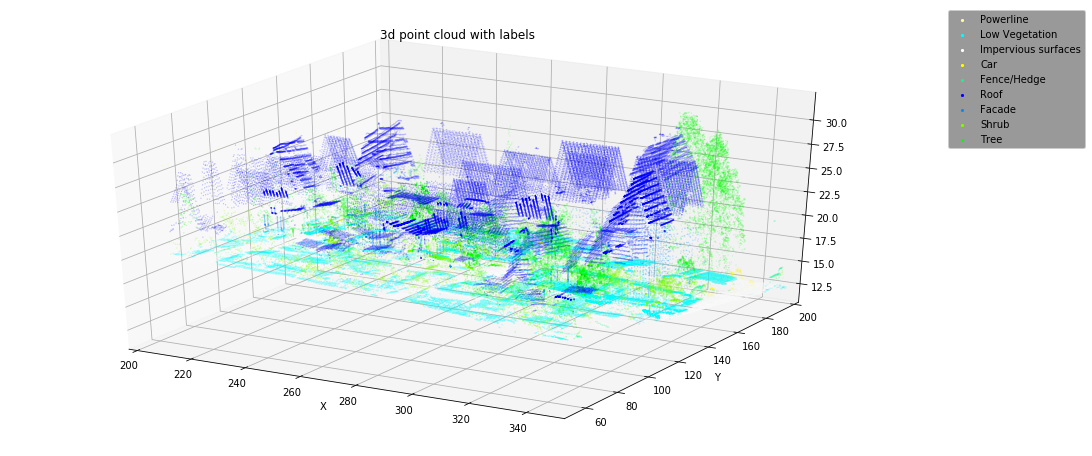

In [6]:
plot_graph_3D(patch2, 
              figsize=(16, 8), 
              marksize=0.02, 
              markerscale=15, 
              xRange=(200, 350), 
              yRange=(50 , 200))

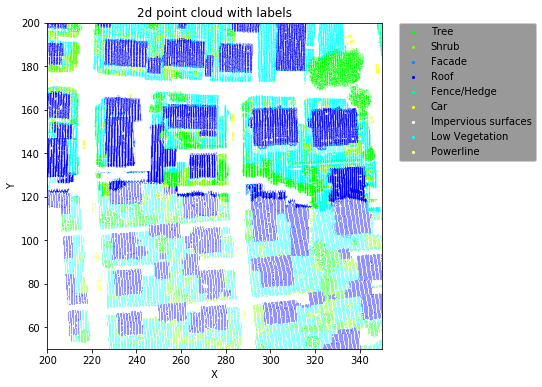

In [7]:
plot_graph_2D(patch2, 
              figsize=(6,6), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(200, 350), 
              yRange=(50 , 200))

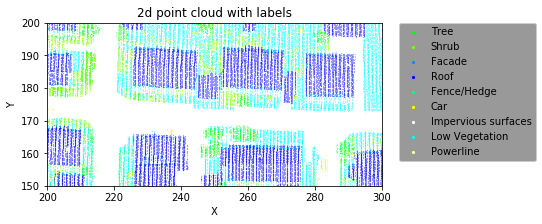

In [8]:
plot_graph_2D(intersection, 
              figsize=(6,3), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(200, 300), 
              yRange=(150, 200))

# 2 Graph Construction 

## 2.1 Generating Graph

Five types of graph are generated in the following way:  
1) When type is '30nn', connect 30 nearest neighbors of a particular node.  
2) When type is 'r101', connect neighbors within the radius of 1.1.  

Then, it remains to calculate the weights:  
1) Gaussian: Use Euclidean distance. Weight is calculated by: $$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{2\sigma^2} \right)$$  
Where $\sigma$ is the mean value of all distances.

2) Binary: Set all weights to be 1 if connected.

3) Local: Comparing to Gaussian, only $\sigma$ changes here.$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma_i \sigma_j} \right)$$  
Where $\sigma_i$ is the distance between node $i$ and its farthest neighbor, the same for node $j$.



### Use the Number of Neighbors

In [7]:
#30nn, Gaussian kernel
G_30nn_Gaussain1, l1  = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                                      mode='distance', neightype='number', lap_type='combinatorial', norm=True)
#30nn, Binary graph
G_30nn_Binary1, l2    = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                                      mode='connectivity', neightype='number', lap_type='combinatorial', norm=True)
#30nn, Local scaling
G_30nn_Local1, l3     = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                                      mode='local', neightype='number', lap_type='combinatorial', norm=True)

In [8]:
#30nn, Gaussian kernel
G_30nn_Gaussain2, l4 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                     mode='distance', neightype='number', lap_type='combinatorial', norm=True)
#30nn, Binary graph
G_30nn_Binary2, l5   = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                     mode='connectivity', neightype='number', lap_type='combinatorial', norm=True)
#30nn, Local scaling
G_30nn_Local2, l6    = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                     mode='local', neightype='number', lap_type='combinatorial', norm=True)

### Use the Radius to Find Neighbors

In [9]:
#r1.1, Gassian kernel
G_r101_Gaussain1, l7 = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                     mode='distance', neightype='radius', lap_type='combinatorial', norm=True)
#r1.1, Binary graph
G_r101_Binary1, l8   = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                     mode='connectivity', neightype='radius', lap_type='combinatorial', norm=True)

In [10]:
#r1.1, Gassian kernel
G_r101_Gaussain2, l9 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                     mode='distance', neightype='radius', lap_type='combinatorial', norm=True)
#r1.1, Binary graph
G_r101_Binary2, l10 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                    mode='connectivity', neightype='radius', lap_type='combinatorial', norm=True)

## 2.2  Gaussian Kernel Visualization

In [11]:
# Get a list of distance for each Gaussian graph
_, dists1 = gsp.knn_w(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                      mode='distance', neightype='number')
_, dists2 = gsp.knn_w(cloud=patch1[['x', 'y', 'z']], r=1.1, dist3D=False, 
                      mode='distance', neightype='radius')
_, dists3 = gsp.knn_w(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                      mode='distance', neightype='number')
_, dists4 = gsp.knn_w(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False,
                      mode='distance', neightype='radius')
dists     = [dists1, dists2, dists3, dists4]

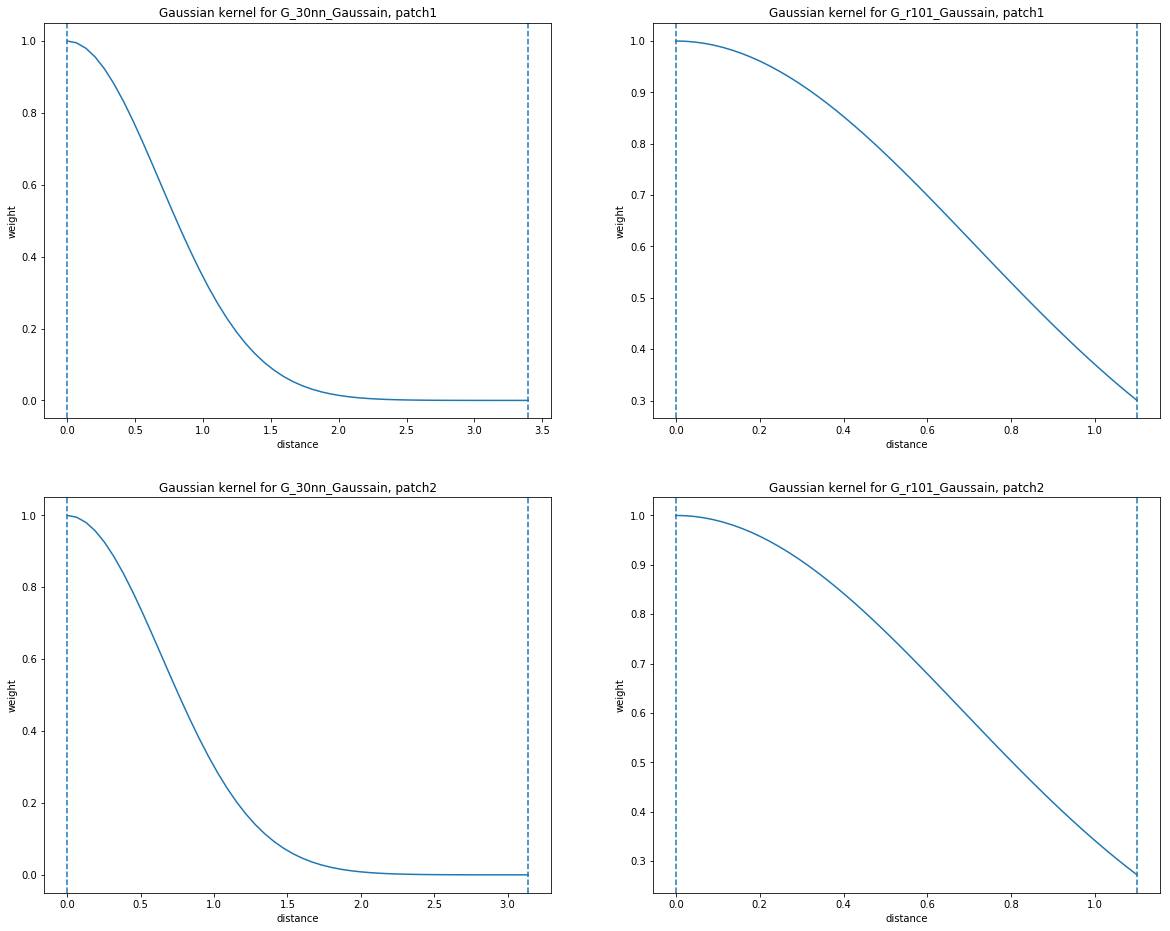

In [12]:
# Weight-Distance Plot
tmp        = [np.array(i) for i in dists]
s          = [np.mean(i[i!=0]) for i in tmp]
d_max      = [np.max(i) if j%2 == 0 else 1.1 for i, j in zip(dists, range(4))]
d_min      = [np.min(i) for i in dists]
title_list = ['Gaussian kernel for G_30nn_Gaussain, patch1',
              'Gaussian kernel for G_r101_Gaussain, patch1',
              'Gaussian kernel for G_30nn_Gaussain, patch2',
              'Gaussian kernel for G_r101_Gaussain, patch2']

# Plot Gaussian kernel
fig, axes  = plt.subplots(2, 2, figsize=(20, 16))
for i in range(4):
    ax = axes[i//2, i%2]
    x = np.linspace(d_min[i], d_max[i], 50)
    y = s[i]*np.sqrt(2*np.pi)*stats.norm.pdf(x, 0, s[i])
    ax.plot(x, y)
    ax.set_xlabel('distance')
    ax.set_ylabel('weight')
    ax.axvline(x=d_min[i], linestyle='--')
    ax.axvline(x=d_max[i], linestyle='--')
    ax.set_title(title_list[i])

# 3 POI detection

## 3.1 Mexican Hat Filter Construction

In [16]:
# Create graph list
graph_list  = [G_30nn_Gaussain1, G_30nn_Binary1, G_30nn_Local1, G_r101_Gaussain1, G_r101_Binary1,
               G_30nn_Gaussain2, G_30nn_Binary2, G_30nn_Local2, G_r101_Gaussain2, G_r101_Binary2]

# Initialize filters dictionary
filter_dict = dict.fromkeys(['g_MH_30nn_Gaussain', 'g_MH_30nn_Binary', 'g_MH_30nn_Local', 
                             'g_MH_r101_Gaussain', 'g_MH_r101_Binary'])
for i, idx in zip(filter_dict.keys(), range(5)):
    filter_dict[i] = []
    if 'nn' in i:
        filter_dict[i].append(filters.MexicanHat(graph_list[idx], Nf=1+len([1.5]), lpfactor=1, scales=[1.5]))
        filter_dict[i].append(filters.MexicanHat(graph_list[idx+5], Nf=1+len([1.5]), lpfactor=1, scales=[1.5]))
    else:
        filter_dict[i].append(filters.MexicanHat(graph_list[idx], Nf=1+len([1.5]), lpfactor=1, scales=[1.5]))
        filter_dict[i].append(filters.MexicanHat(graph_list[idx+5], Nf=1+len([1.5]), lpfactor=1, scales=[1.5]))             

## 3.2 Visualization Filters

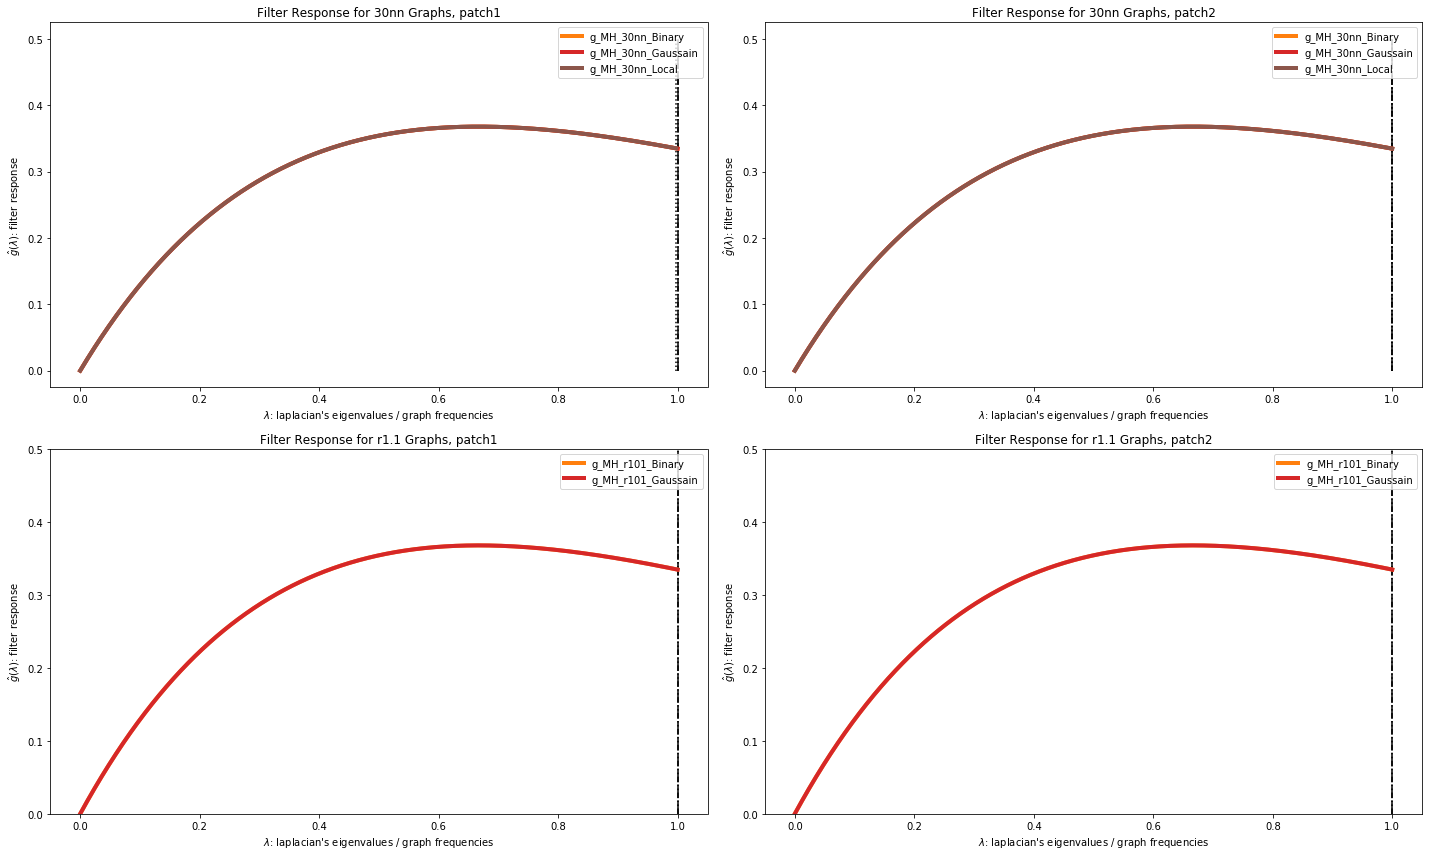

In [19]:
title_list = ['Filter Response for 30nn Graphs, patch1',
              'Filter Response for 30nn Graphs, patch2',
              'Filter Response for r1.1 Graphs, patch1',
              'Filter Response for r1.1 Graphs, patch2']

# Visualize filters
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
for k in range(4):
    ax = axes[k//2, k%2]
    if k < 2:
        for i,j in zip(itemgetter(*[1, 0, 2])(list(filter_dict.keys())), range(3)):
            filter_dict[i][k].plot(ax=ax, show_sum=False)
            ax.lines.pop(j)
        ax.vlines(graph_list[0+k*5].lmax, 0, 0.5, 'k', '--')
        ax.vlines(graph_list[1+k*5].lmax, 0, 0.5, 'k', '-.')
        ax.vlines(graph_list[2+k*5].lmax, 0, 0.5, 'k', ':')
        ax.set_title(title_list[k])
        ax.legend(itemgetter(*[1, 0, 2])(list(filter_dict.keys())))
    else:
        for i,j in zip(itemgetter(*[4, 3])(list(filter_dict.keys())), range(2)):
            filter_dict[i][k%2].plot(ax=ax, show_sum=False)
            ax.lines.pop(j)
        ax.set_ylim(0, 0.5)
        ax.vlines(graph_list[3+(k-2)*5].lmax, 0, 0.5, 'k', '--')
        ax.vlines(graph_list[4+(k-2)*5].lmax, 0, 0.5, 'k', '-.')
        ax.set_title(title_list[k])
        ax.legend(itemgetter(*[4, 3])(list(filter_dict.keys())))
plt.tight_layout()

The frequency range of filter is normalized to be between 0 and 1.

## 3.3 POI Detection and Visualization

In [20]:
threshold_nn = [0.2, 0.2, 0.2]
threshold_r  = [0.1, 0.1]

# Create signal dictionary
signal_dict = dict.fromkeys(['s_30nn_Gaussain', 's_30nn_Binary', 's_30nn_Local',
                             's_r101_Gaussain', 's_r101_Binary'])
# Create edge index dictonary, highlight nodes that have high frequency
edge_dict   = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_30nn_Binary', 'edgeind_30nn_Local',
                             'edgeind_r101_Gaussain', 'edgeind_r101_Binary'])

for i, j, k, m in zip(signal_dict.keys(), filter_dict.keys(), edge_dict.keys(), range(5)):
    signal_dict[i] = []
    edge_dict[k] = []
    signal_dict[i].append(filter_dict[j][0].filter(patch1.z, method = 'chebyshev'))
    signal_dict[i].append(filter_dict[j][1].filter(patch2.z, method = 'chebyshev'))
    if 'nn' in i:
        edge_dict[k].append(signal_dict[i][0][:, -1] >= threshold_nn[m])
        edge_dict[k].append(signal_dict[i][1][:, -1] >= threshold_nn[m])
    else:
        edge_dict[k].append(signal_dict[i][0][:, -1] >= threshold_r[m-3])
        edge_dict[k].append(signal_dict[i][1][:, -1] >= threshold_r[m-3])

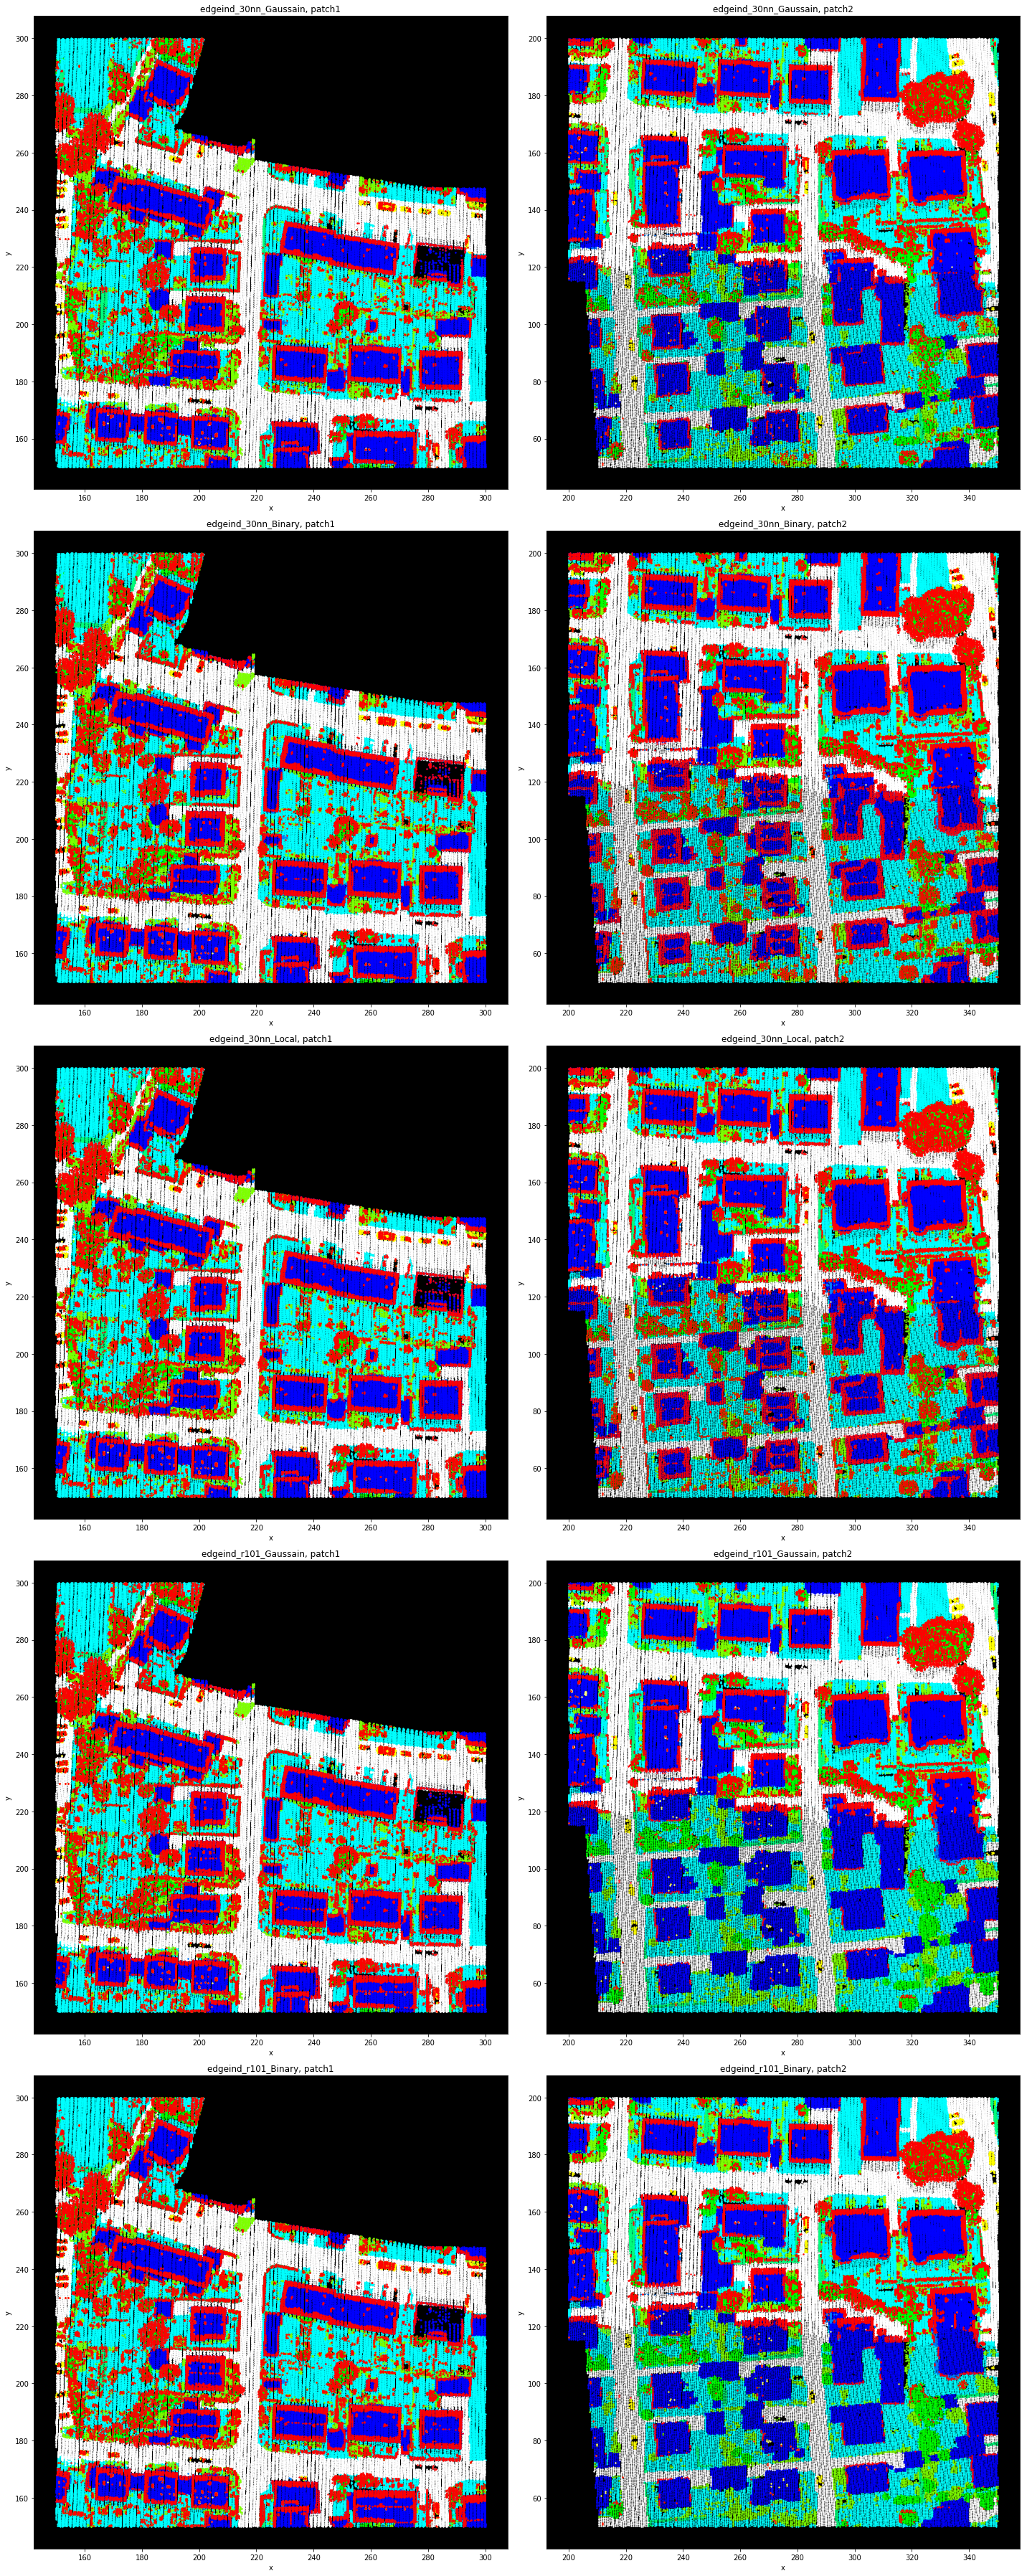

In [21]:
patch     = [patch1, patch2]
fig, axes = plt.subplots(5, 2, figsize=(20, 50))
for i, k in zip([val for val in edge_dict.keys() for _ in (0, 1)], range(10)):               
    if 'nn' in i:
        gspplot.plot_vaihingen_2D(patch[k%2], 
                                  id_highlight=np.nonzero(edge_dict[i][k%2])[0], 
                                  ax=axes[k//2,k%2], 
                                  label_high='Edges', 
                                  title="{}, patch{}".format(i,k%2+1))
    else:
        gspplot.plot_vaihingen_2D(patch[k%2], 
                                  id_highlight=np.nonzero(edge_dict[i][k%2])[0], 
                                  ax=axes[k//2,k%2], 
                                  label_high='Edges', 
                                  title="{}, patch{}".format(i, k%2+1))
plt.tight_layout()

30nn binary graph and 30nn local graph csn cure unequal point density distribution, while other types of graph detect thicker roof edges in the dense area but thinner ones in the sparse area.

## 3.4 Setting Ground Truth

I use the 30nn Binary graph to prepare for the ground truth. The signal value of the building nodes is 1, while that of other nodes is 0.

But the problem is that some points in the body of the buildings come out. They seem to surround the powerline points. So I do the following procedures: 1) If the nodes belong to roofs or powerlines, set the signal to be 1. 2) Remove the positive false points after filtering the signal. We cannot delete those powerline points in the dataframe because the indices are changed in this way. 

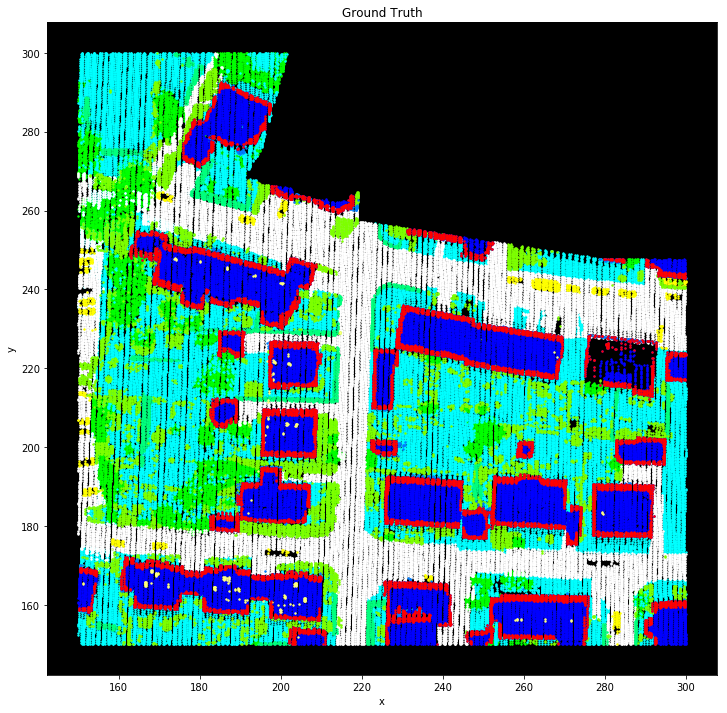

In [22]:
df_patch1, edge_roof1 = set_ground_truth(patch=patch1, 
                                         threshold=0.08, 
                                         f=filter_dict['g_MH_30nn_Binary'][0], 
                                         figsize=(12, 12))

It is very hard to remove gambling roof, because we start to lose other edge points if incresing the threshlod.

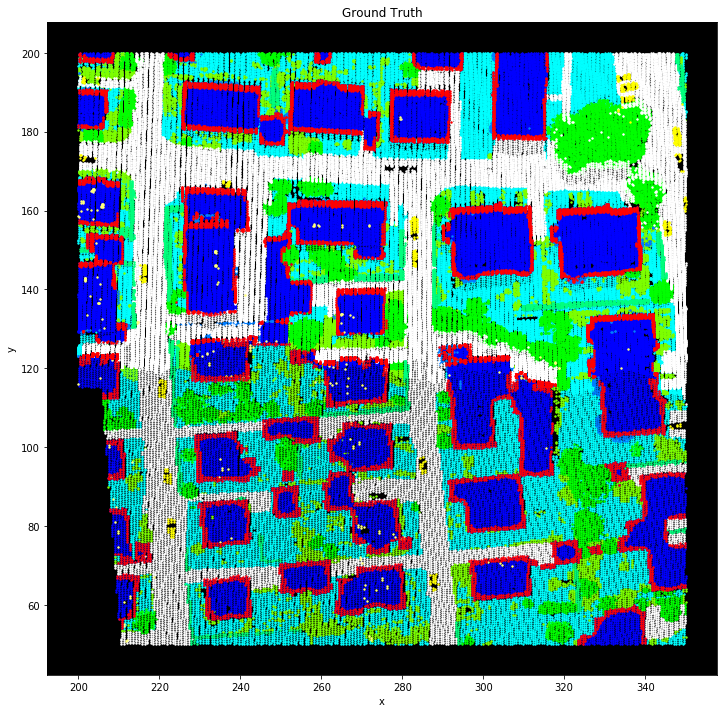

In [23]:
df_patch2, edge_roof2 = set_ground_truth(patch=patch2, 
                                         threshold=0.08, 
                                         f=filter_dict['g_MH_30nn_Binary'][1], 
                                         figsize=(12, 12))

In [24]:
# Obtain points of interest in the intersection part of the two patches
df_intersect = df_patch1[df_patch1['index'].isin(list(intersection.index))]
df_intersect.reset_index(drop=True, inplace=True)
intersect_points  = list(df_patch1[df_patch1['index'].isin(list(intersection.index))].index)
intersection_roof = edge_roof1[intersect_points]
intersection_edge_dict = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_30nn_Binary', 'edgeind_30nn_Local',
                                        'edgeind_r101_Gaussain', 'edgeind_r101_Binary'])

for i in intersection_edge_dict.keys():
    intersection_edge_dict[i] = []
    tmp1 = edge_dict[i][0][intersect_points]
    tmp2 = edge_dict[i][1][list(df_patch2[df_patch2['index'].isin(list(intersection.index))].index)]
    intersection_edge_dict[i].extend((tmp1, tmp2))

## 3.5 Graph Quantitative Comparison

The tables below shows what the highligted points are composed of in each type of the graph. The column named total calculate the total number of points that come out after filtering in each graph representation. Other columns like precision and recall are calculated in the following way:

Precision = $\frac{detected\ points\ \cap \ GT}{detected\ points}$  
Recall (reference to ground truth) = $\frac{detected\ points\ \cap \ GT}{GT}$  
Recall (reference to label) = $\frac{detected\ points\ \cap \ roof\ points}{roof\ points}$

Table for patch1 

In [25]:
qua_comp_df(df =comp_df(patch1, edge_dict=edge_dict, labels=labels, num=0),
            df2=df_patch1,
            num=0,
            edge_roof=edge_roof1, 
            edge_dict=edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
r101_Binary     0.005879        0.025053             0.001796  0.019608   
r101_Gaussain   0.005975        0.025618             0.001804  0.018548   
30nn_Binary     0.006229        0.017743             0.001573  0.020103   
30nn_Local      0.006505        0.017681             0.001568  0.019216   
30nn_Gaussain   0.007097        0.014307             0.001502  0.012655   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
r101_Binary       0.055377  0.391259  0.012396  0.168390  0.320242  34527   
r101_Gaussain     0.053335  0.387132  0.012898  0.171069  0.323621  33805   
30nn_Binary       0.050115  0.419291  0.011671  0.148174  0.325101  31787   
30nn_Local        0.047106  0.411476  0.012344  0.149425  0.334679  29975   
30nn_Gaussain     0.041194  0.413218  0.013406  0.142922  0.353699  26630   

               Precision  Recall_GT  Recall_roof  
r101_Binary     0.266574   0.855311     0.365385  
r101_Gaussain   0.270374   0.849363     0.353971  
30nn_Binary     0.285588   0.843602     0.360489  
30nn_Local      0.298682   0.831986     0.333604  
30nn_Gaussain   0.321630   0.795930     0.297631

Table for patch2

In [26]:
qua_comp_df(df =comp_df(patch2, edge_dict=edge_dict, labels=labels, num=1),
            df2=df_patch2,
            num=1,
            edge_roof=edge_roof2, 
            edge_dict=edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
30nn_Binary     0.005731        0.016501             0.002104  0.008528   
30nn_Local      0.005984        0.017069             0.002270  0.007665   
30nn_Gaussain   0.007193        0.009108             0.000665  0.002072   
r101_Binary     0.005666        0.005590             0.000306  0.000995   
r101_Gaussain   0.005759        0.005396             0.000282  0.001007   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
30nn_Binary       0.044216  0.497951  0.036215  0.101611  0.287142  36118   
30nn_Local        0.043069  0.480720  0.040328  0.106185  0.296710  33922   
30nn_Gaussain     0.028029  0.484266  0.050272  0.086119  0.332278  25581   
r101_Binary       0.024618  0.529691  0.052376  0.067767  0.312991  26119   
r101_Gaussain     0.021021  0.521827  0.057829  0.067413  0.319467  24832   

               Precision  Recall_GT  Recall_roof  
30nn_Binary     0.323661   0.858297     0.304093  
30nn_Local      0.333117   0.829662     0.275722  
30nn_Gaussain   0.385521   0.724082     0.209458  
r101_Binary     0.329530   0.631938     0.233925  
r101_Gaussain   0.342099   0.623715     0.219096

Table for the intersection part evaluated on patch1

In [27]:
qua_comp_df(df =comp_df(intersection, edge_dict=intersection_edge_dict, labels=labels, num=0),
            df2=df_intersect,
            num=0,
            edge_roof=intersection_roof, 
            edge_dict=intersection_edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
r101_Binary     0.004727        0.057115             0.002068  0.006204   
r101_Gaussain   0.004771        0.058262             0.001929  0.005177   
30nn_Binary     0.004854        0.047987             0.001875  0.008053   
30nn_Local      0.005223        0.048309             0.001899  0.007478   
30nn_Gaussain   0.005667        0.039266             0.001754  0.005532   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
r101_Binary       0.050517  0.567110  0.013097  0.151157  0.148006  10155   
r101_Gaussain     0.048011  0.564657  0.014007  0.154486  0.148701   9852   
30nn_Binary       0.044015  0.601213  0.013017  0.124876  0.154109   9065   
30nn_Local        0.037745  0.597864  0.013531  0.130445  0.157507   8425   
30nn_Gaussain     0.026177  0.617865  0.014573  0.126838  0.162326   7411   

               Precision  Recall_GT  Recall_roof  
r101_Binary     0.377745   0.904290     0.369854  
r101_Gaussain   0.386825   0.898397     0.357267  
30nn_Binary     0.410921   0.878124     0.350010  
30nn_Local      0.439169   0.872230     0.323486  
30nn_Gaussain   0.487653   0.851957     0.294072

Table for the intersection part evaluated on patch2

In [28]:
qua_comp_df(df =comp_df(intersection, edge_dict=intersection_edge_dict, labels=labels, num=1),
            df2=df_intersect,
            num=1,
            edge_roof=intersection_roof, 
            edge_dict=intersection_edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
30nn_Binary     0.005144        0.047554             0.001715  0.008002   
30nn_Local      0.005319        0.048839             0.001813  0.007012   
30nn_Gaussain   0.005339        0.021828             0.001570  0.004554   
r101_Binary     0.004516        0.008845             0.000188  0.003952   
r101_Gaussain   0.004775        0.008556             0.000199  0.004377   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
30nn_Binary       0.040809  0.599680  0.013489  0.128372  0.155235   8748   
30nn_Local        0.033849  0.600580  0.013902  0.131770  0.156915   8272   
30nn_Gaussain     0.019943  0.645572  0.017274  0.115421  0.168499   6368   
r101_Binary       0.013549  0.706624  0.016184  0.081107  0.165036   5314   
r101_Gaussain     0.013530  0.700159  0.018703  0.079785  0.169916   5026   

               Precision  Recall_GT  Recall_roof  
30nn_Binary     0.423411   0.873173     0.336908  
30nn_Local      0.445479   0.868694     0.319055  
30nn_Gaussain   0.542085   0.813767     0.264016  
r101_Binary     0.593527   0.743517     0.241153  
r101_Gaussain   0.613012   0.726308     0.225997

From the tables above, we know that 30nn binary graph and 30nn local graph have comparable performance on patch 1 and patch 2. 30nn Binary graph has better performance.